# APM 466 Assignment 1

In [1]:
%pylab
%matplotlib inline
pylab.rcParams['figure.figsize'] = (12,6)

import scipy.interpolate
import pandas as pd
from datetime import datetime
import numpy as np
import tvm
import json
from numpy import linalg as LA
from math import pow, floor, ceil, log, fabs

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


### Helper Functions

In [2]:
def clean_df(df):
    coupon = []
    current_date = datetime(2023,1,30)
    df['maturity_date'] = pd.to_datetime(df['maturity_date'])
    for i in range(df1.shape[0]):
        coupon.append(float(df['coupon'][i].split('%')[0]))
    df['coupon'] = coupon
    df[['bid','ask']] = df[['bid','ask']].replace('-','NaN').astype(float)
    df[['coupon']] = df[['coupon']].astype(float)
    df['close0'] = (df['bid']+df['ask'])/2
    df = df.drop(columns=['bid','ask'])
    df = df.reindex(columns=['maturity_date', 'bond_yield', 'coupon', 'close0'])
    return df

def combine_dfs(frames):
    df = frames[0]
    for i in range(1,10):
        extracted_col = frames[i]['close0']
        df[f'close{i}'] = extracted_col
        
    # add ttm
    ttm = []
    for i in range(df.shape[0]):
        time = datetime(2023,1,29) - df['maturity_date'][i]
        time_yr = int(str(time.days)[1:])/365
        ttm.append(time_yr)
    df['ttm'] = ttm
    return df

def generate_tr(df):
    tr = []
    for i, bond in df.iterrows():
        ttm = bond['ttm']
        tr.append(ttm)
    return tr

def generate_ytms(df):
    all_ytms = []
    for i in range(10):
        ytm_single = []
        for j, bond in df.iterrows():
            ttm = bond['ttm']
            price = bond['close' + str(i)]
            freq = 2
            ytm = tvm.TVM(n=ttm*freq, pv=-price, pmt=bond['coupon']/freq, fv=100).calc_r() * freq

            ytm_single.append(ytm)
        all_ytms.append(ytm_single)
    return all_ytms

def generate_spot_rates(all_ytms):
    y_vals_sr = []
    for i in range(10):
        daily_spot_rate = spot_rates(all_ytms[i], t)
        y_vals_sr.append(daily_spot_rate)
    return y_vals_sr

def generate_fwd_rates(y_vals_sr):
    y_vals_fr = []
    for i in range(10):
        daily_forward_rate = forward_rates(y_vals_sr[i])
        y_vals_fr.append(daily_forward_rate)
    return y_vals_fr

def interpolate(all_ytms, ttms):
    y = []
    for ys in all_ytms:
        ytm = []
        cs = scipy.interpolate.CubicSpline(ttms,ys,bc_type='natural')
        x = np.linspace(0, 5,10)
        z = cs(x)

        for i in z:
            value = float(i)
            ytm.append(value)

        y.append(ytm)
    return y

def spot_rates(y, t):
    sr = []  # output array for spot rates
    for i in range(len(t)):  # calculate i-th spot rate
        thesum = 0
        for j in range(0, i):  # by iterating through 0..i
            thesum += y[i] / (1 + sr[j]) ** t[j]
        value = ((1 + y[i]) / (1 - thesum)) ** (1 / t[i]) - 1
        sr.append(value)        
    return sr

def forward_rates(spot_rates):
    fr = []
    r = spot_rates[2]
    counter = 3
    k = 2
    while (counter < len(spot_rates)):
        sr = spot_rates[counter]
        forward_rate = float((sr * k  - r) / (k - 1))
        fr.append(forward_rate)
        k += 1
        counter += 2
    return fr

def log_returns(x,y,the_list):
    log_returns = np.zeros((x, y))
    for i in range(len(the_list)):
        for j in range(len(the_list)-1):
            log_returns[i][j] = math.log(the_list[i][j]/the_list[i][j+1])
            
    return log_returns

## Fundamental Questions 

### Question 1

#### 1a) Why do governments issue bonds and not simply print more money?
Governments issue bonds as a way to borrow money from investors to raise funds to finance projects.

#### 1b)	Give a hypothetical example of why the long-term part of a yield curve might flatten.
The long-term part of the yield curve might flatten when investors expect inflation to remain low, which results in a reduced demand for a higher yield in long term yields, causing the yield curve to flatten.

#### 1c) Explain what quantitative easing is and how the (US) Fed has employed this since the beginning of the COVID-19 pandemic.

QE is a monetary policy to increase the money supply and stimulate economic growth, where the Fed has purchased large amounts of T-bonds and mortgage-backed securities to inject liquidity into the market.


### Question 2

### Extracting data from json files into Dataframes.
Data has been scraped from the web from 16 Jan to 27 Jan.

In [3]:
# Extract data from webscraping file
df1 = pd.read_json('APM466/Data/16Jan.json').set_index(['name']).sort_values(['maturity_date'], ascending=[True])
df2 = pd.read_json('APM466/Data/17Jan.json').set_index(['name']).sort_values(['maturity_date'], ascending=[True])
df3 = pd.read_json('APM466/Data/18Jan.json').set_index(['name']).sort_values(['maturity_date'], ascending=[True])
df4 = pd.read_json('APM466/Data/19Jan.json').set_index(['name']).sort_values(['maturity_date'], ascending=[True])
df5 = pd.read_json('APM466/Data/20Jan.json').set_index(['name']).sort_values(['maturity_date'], ascending=[True])
df6 = pd.read_json('APM466/Data/23Jan.json').set_index(['name']).sort_values(['maturity_date'], ascending=[True])
df7 = pd.read_json('APM466/Data/24Jan.json').set_index(['name']).sort_values(['maturity_date'], ascending=[True])
df8 = pd.read_json('APM466/Data/25Jan.json').set_index(['name']).sort_values(['maturity_date'], ascending=[True])
df9 = pd.read_json('APM466/Data/26Jan.json').set_index(['name']).sort_values(['maturity_date'], ascending=[True])
df10 = pd.read_json('APM466/Data/27Jan.json').set_index(['name']).sort_values(['maturity_date'], ascending=[True])


In [4]:
# Clean dataframe
df1 = clean_df(df1)
df2 = clean_df(df2)
df3 = clean_df(df3)
df4 = clean_df(df4)
df5 = clean_df(df5)
df6 = clean_df(df6)
df7 = clean_df(df7)
df8 = clean_df(df8)
df9 = clean_df(df9)
df10 = clean_df(df10)


In [5]:
frames = [df1,df2,df3,df4,df5,df6,df7,df8,df9,df10]
df = combine_dfs(frames).reset_index()

### Question 2
I scraped data off the given website using a webscrapping library known as BeautifulSoup. The 10 bonds (as seen in the DataFrame below) are chosen because these 10 bonds are the most evenly distributed bonds among the 41 bonds withiin a 5-year window and that the coupon rates are not drastically different from one another.

In [37]:
arr = [0,3,6,11,15,19,21,23, 25, 27] # row number of bonds
df = df.loc[arr]
df.iloc[:,:4]

,name,maturity_date,bond_yield,coupon
0,CAN 0.25 Feb 23,2023-02-01,-,0.25
3,CAN 1.50 Jun 23,2023-06-01,4.52%,1.50
6,CAN 0.50 Nov 23,2023-11-01,4.45%,0.50
11,CAN 2.50 Jun 24,2024-06-01,3.99%,2.50
15,CAN 3.00 Nov 24,2024-11-01,3.77%,3.00
19,CAN 2.25 Jun 25,2025-06-01,3.47%,2.25
21,CAN 0.50 Sep 25,2025-09-01,3.51%,0.50
23,CAN 0.25 Mar 26,2026-03-01,3.36%,0.25
25,CAN 1.00 Sep 26,2026-09-01,3.19%,1.00
27,CAN 1.00 Jun 27,2027-06-01,2.93%,1.00


### Question 3
The eigenvalues associated with the covariance matrix of these stochastic processes tells us about the characteristics of the yield curve. The eigenvalues tells us about how much of the variance can be explained by its corresponding eigenvector. The largest eigenvalue will account for the largest explained variance and the second eigenvalue will account for the second largest amount of explained variance and so on

## Empirical Questions
### Question 4a

These are the assumptions made in the calculations
- 1 year = 365 days 
- Today's date = 30 January 2023

In [38]:
# We will use a same ttm as it does not change much over 10 days
tr = generate_tr(df)
all_ytms = generate_ytms(df)

#### Interpolation
I chose to interpolate the yield curve using the Cubic Spine Interpolation technique because this method of interpolation can avoid the problem of Runge's phenomenon. This method also gives an interpolating polynomial that is smoother and has smaller error than some other interpolating polynomials such as Lagrange polynomial and Newton polynomial.

In [8]:
t = list(i for i in range(1,df.shape[0]+1))
dates = ["16-Jan", "17-Jan", "18-Jan", "19-Jan", "20-Jan", "23-Jan", "24-Jan", "25-Jan", "26-Jan", "27-Jan"]

In [9]:
all_ytms = interpolate(all_ytms, tr)

#### Yield Curve

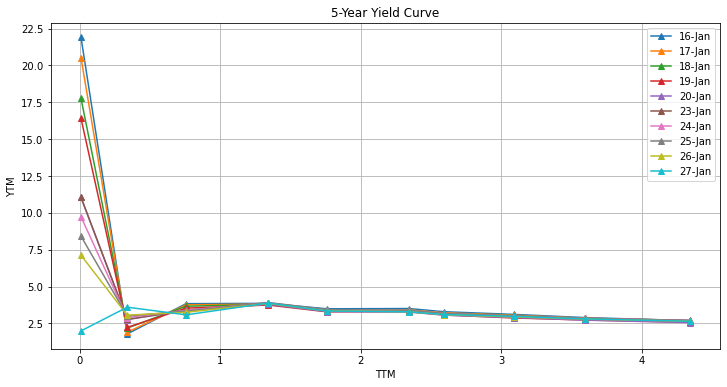

In [10]:
plt.xlabel('TTM'), plt.ylabel('YTM'), plt.title('5-Year Yield Curve'), grid(True)
for i in range(10):
    ytm = all_ytms[i]
    curve_label = dates[i]
    plot(tr, array(ytm)*100, marker='^', label=curve_label)
legend(loc=1), show();

### Question 4b

#### Calculating the Spot Rate via Bootstrapping
Because Treasury notes and bonds are generally issued as coupon bonds, their prices cannot simply be used to construct the spot rate curve or to calculate forward rates. Instead, a theoretical spot rate curve and implied forward rates are constructed through the process of bootstrapping which calculates the forward rates by considering the value of the zero coupon bonds equivalent to the Treasury bonds. The calculated forward rates can then construct the spot-rate curve by adding the yields for each term to the desired maturity.

The bootstrapping technique is based on the price-yield equation using different rates for each of the 6-month terms, as determined by market prices:

$$
   \frac{C}{(1 + rate)^1}\ + \frac{C}{(1 + rate)^2}\ + \ ... \ + \frac{C}{(1 + rate)^i}\ = \ 100
$$

In [19]:
# Bootstrapping to calculate spot rates
y_vals_sr = generate_spot_rates(all_ytms)

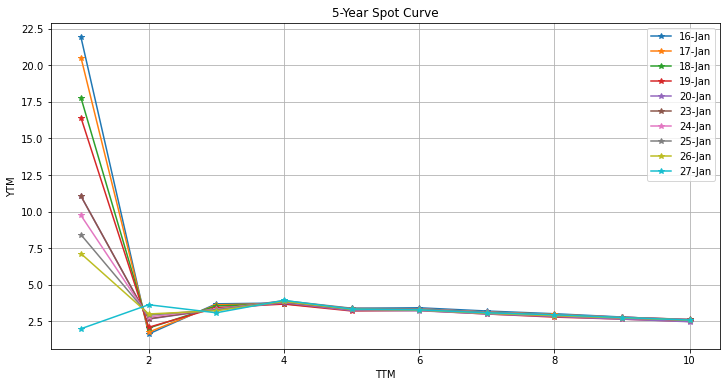

(<matplotlib.legend.Legend at 0x7fdaa0b16dc0>, None)

In [12]:
xlabel('TTM'), ylabel('YTM'), plt.title('5-Year Spot Curve'), grid(True)

for i in range(10):
    y_val = y_vals_sr[i]
    curve_label = dates[i]
    plot(t, array(y_val)*100, marker='*', label=curve_label)
    
legend(loc=1), show()

### Question 4c

#### Calculating the Forward Rates

Forward Rate, f can be derived through the following formula:

$$
f = \frac{(r_a + 1)^{t_a}}{(r_b + 1)^{t_b}} - 1
$$ 

where 
$r_a$ = the spot rate for the bond of term $t_a$ periods and
$r_b$ = the spot rate for the bond with a shorter term of $t_b$ periods.

After obtaining the 1y forward points from the formua via the spot rate obtained previously, I can get the estimate of 1y-1y, 1y-2y, 1y-3y annd 1y-4y forward rates via interpolation. The graph will be as follows:

In [21]:
# Calculating the forward rates
y_vals_fr = generate_fwd_rates(y_vals_sr)

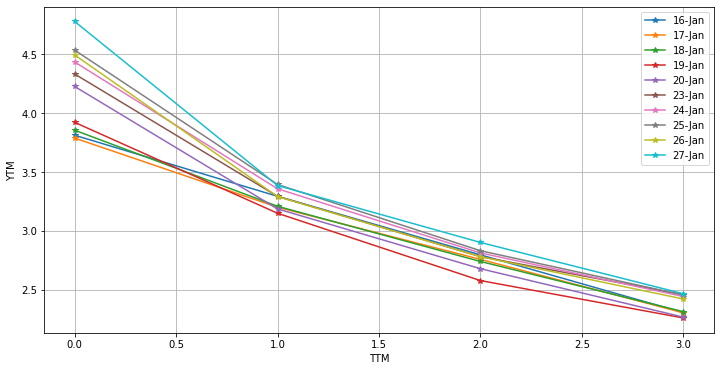

(<matplotlib.legend.Legend at 0x7fdab34a57c0>, None)

In [14]:
t_fr = [0,1,2,3]
xlabel('TTM'), ylabel('YTM'), grid(True)

for i in range(10):
    y_val = y_vals_fr[i]
    curve_label = dates[i]
    plot(t_fr, array(y_val)*100, marker='*', label=curve_label)
    
legend(loc=1), show()

### Question 5

#### Calculating the covariance matrix of daily log-returns of yield

In [15]:
ytm_list = []
for i in range(10):
    j = 1
    temp = []
    while (j < len(all_ytms[0])):
        temp.append(all_ytms[i][j])
        j += 2
    ytm_list.append(temp)
ytm_list = np.array(ytm_list).transpose()
ytm_cov = np.cov(log_returns(5,9,ytm_list))
ytm_cov

array([[ 5.93307720e-03,  2.00677298e-04, -2.92069194e-04,
         1.90337941e-04, -2.01661816e-04],
       [ 2.00677298e-04,  5.67576582e-05,  4.75348547e-05,
         9.99166352e-05,  2.34500525e-05],
       [-2.92069194e-04,  4.75348547e-05,  1.15417173e-04,
         1.45725435e-04,  8.32733598e-05],
       [ 1.90337941e-04,  9.99166352e-05,  1.45725435e-04,
         3.24902121e-04,  1.42025828e-04],
       [-2.01661816e-04,  2.34500525e-05,  8.32733598e-05,
         1.42025828e-04,  8.72561699e-05]])

In [16]:
ytm_eigenvalues, ytm_vectors = LA.eig(ytm_cov)
print('The eigenvalues for the log-returns of yield are: \n', ytm_eigenvalues)
print()
print('The eigenvectors for the log-returns of yield are: \n', ytm_vectors)
print()

The eigenvalues for the log-returns of yield are: 
 [5.96729969e-03 4.98115951e-04 3.59566644e-05 1.60380122e-05
 1.74942781e-20]

The eigenvectors for the log-returns of yield are: 
 [[ 9.97120281e-01 -7.18173916e-04 -1.38979554e-02  7.45381945e-02
   1.23823503e-03]
 [ 3.38671721e-02  2.43790680e-01  7.19318920e-01 -3.25917636e-01
   5.61940481e-01]
 [-4.91754200e-02  4.14187756e-01  4.28307195e-01  7.46535842e-01
  -2.92005932e-01]
 [ 3.21106663e-02  7.93828988e-01 -2.06815322e-01 -4.54730648e-01
  -3.45328690e-01]
 [-3.39829726e-02  3.72625320e-01 -5.06129932e-01  3.52315237e-01
   6.92605222e-01]]



#### Calculating the covariance matrix of Forward rates

In [17]:
forward_rate_list = []
for i in range(10):
    j = 0
    temp = []
    while (j < len(y_vals_fr[0])):
        temp.append(y_vals_fr[i][j])
        j += 1
    forward_rate_list.append(temp)
forward_rate_list = np.array(forward_rate_list).transpose()
fr_cov = np.cov(log_returns(4,9,forward_rate_list))
fr_cov

array([[ 6.91362437e-05,  5.65704634e-06, -1.02254234e-04,
        -3.33442331e-05],
       [ 5.65704634e-06,  1.18621676e-04,  1.39700114e-04,
         4.52540464e-05],
       [-1.02254234e-04,  1.39700114e-04,  4.04220955e-04,
         1.54368618e-04],
       [-3.33442331e-05,  4.52540464e-05,  1.54368618e-04,
         6.54926050e-05]])

In [18]:
forward_eigenvalues, forward_vectors = LA.eig(fr_cov)
print('The eigenvalues for the log-returns of the 1-yr forward rates are: \n', forward_eigenvalues)
print()
print('The eigenvectors for the log-returns of the 1-yr forward rates are: \n', forward_vectors)

The eigenvalues for the log-returns of the 1-yr forward rates are: 
 [ 5.38863161e-04  9.87648307e-05  1.98434883e-05 -2.48996949e-20]

The eigenvectors for the log-returns of the 1-yr forward rates are: 
 [[ 0.2075892   0.61575043 -0.65326527 -0.38859056]
 [-0.31985926  0.77644867  0.4460466   0.30961257]
 [-0.86461825 -0.1108697  -0.09305873 -0.48112708]
 [-0.32715755 -0.07541074 -0.60467098  0.7222563 ]]


### Question 6
The eigenvector that is associated with the largest eigenvalue tell us how much variance can be explained by its associated eigenvector and it represents the dataset’s largest variation after orthogonal decomposition is in that associated eigenvector’s direction.